In [69]:
import sys, importlib, os, json, h3, uuid, datetime
from types import SimpleNamespace
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import datautils as du
importlib.reload(du)

args = SimpleNamespace()

args.latlon = [34.0522, -118.2437]
args.h3id9 = h3.latlng_to_cell(*args.latlon, res=9)
args.h3id5 = h3.latlng_to_cell(*args.latlon, res=5)[:8]
args.h3id1 = h3.latlng_to_cell(*args.latlon, res=1)[:5]
args.uuid = str(uuid.uuid1())[:18]
args.uuid8 = args.uuid[:8]
args.date = datetime.datetime.now().strftime("%Y%m%d")
args.pid = f'{args.h3id9}-{args.date}-{args.uuid8}'
args.data = SimpleNamespace()
args.data.gcp_root = f'{args.h3id1}/{args.h3id5}/{args.pid}'

du.fetch_meteo(args)

#np.savez('/Users/gamayos/Downloads/test.npz', **args.daily_data, allow_pickle=True)

#with open('/Users/gamayos/Downloads/meteo.json', 'w') as f:
#        json.dump(args.daily_data, f, default=str)

#du.gcp_upload_file(args, '/Users/gamayos/Downloads/meteo.json', f'{args.data.gcp_root}/{args.pid}-meteo.json')
#read data from npz file

#data = np.load('/Users/gamayos/Downloads/test.npz')

#print(data) #['date'].shape)

Coordinates 34.05975341796875°N -118.23750305175781°E
Elevation 91.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [80]:
import pandas as pd

daily = args.meteo_response.Daily()

# leave out the time, leave only the date in the code below
daily_data = {"date": pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True).normalize().strftime('%Y-%m-%d'),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).normalize().strftime('%Y-%m-%d'),
    freq=pd.Timedelta(days=1),
    inclusive="left"
)}
daily_data['juldate'] = daily_data['date'].to_julian_date().astype(int)

print(daily_data['juldate'][:10])

Index([2460269, 2460270, 2460271, 2460272, 2460273, 2460274, 2460275, 2460276,
       2460277, 2460278],
      dtype='int64')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1299014899376112..1.10755626064981].


(55, 360, 4)
(35, 360, 4)
(360, 519, 3)


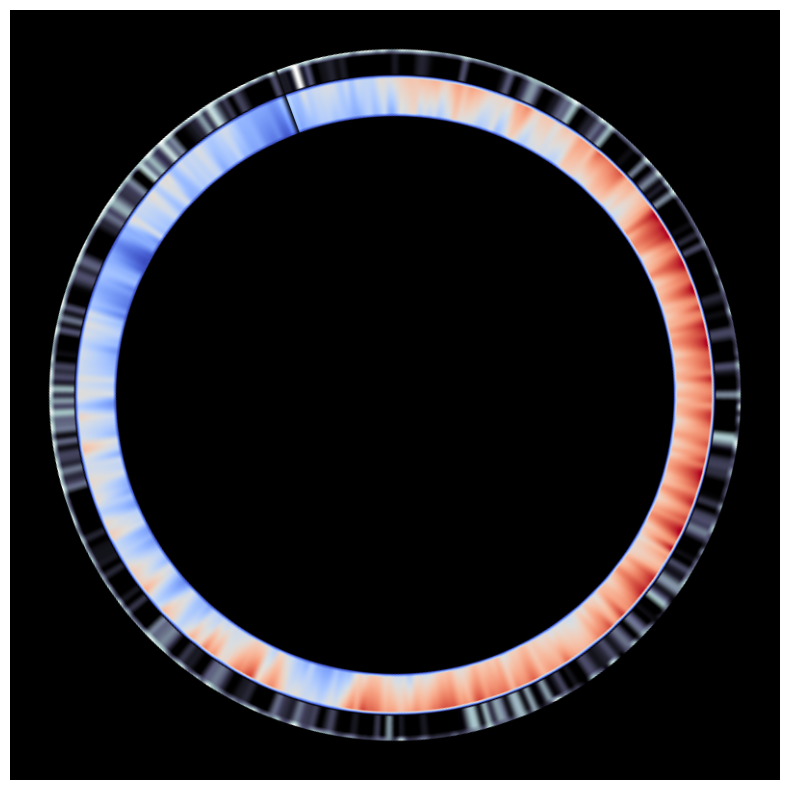

In [37]:
import numpy as np
from skimage import transform

import datautils as du
importlib.reload(du)

ttmat = du.render_temperature(args)
print(ttmat.shape)

ptmat = du.render_precipitation(args)
print(ptmat.shape)

buff = np.array([0,0,0,1])[None,None,:] * np.ones((4,360))[:,:,None]
buff0 = np.array([0,0,0,1])[None,None,:] * np.ones((48,360))[:,:,None]
buff1 = np.array([0,0,0,1])[None,None,:] * np.ones((377,360))[:,:,None]

mmat = np.r_[buff0,buff,ptmat,ttmat,buff1] #,bbands[::-1],buff1]
mmmat = mmat.transpose((1,0,2))[::-1,::-1,:3]
print(mmmat.shape)

mandala1 = du.topolar(mmmat)
mandala1 = transform.rotate(mandala1, 200) #[:,::-1]

fig = plt.figure(figsize=(10,10))
plt.imshow(mandala1)
# make the plot square and take up the whole space
#plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
#plt.tight_layout()
fig.savefig('/Users/gamayos/Downloads/test.png', format='png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [40]:
import uuid, hashlib

#uuid = 's'+hashlib.sha1(bytes(str(uuid.uuid1()), 'utf-8')).hexdigest()[:8]

print(str(uuid.uuid1())[:18])

fd9a7a90-ab1a-11ef


In [19]:
!python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
